# TF acs-2 fluorescence

In [2]:
%matplotlib inline
import os
import sys
import tifffile as tiff
import pandas as pd
import matplotlib
# For visualising
#matplotlib.use('MacOSX') 
# For saving
#matplotlib.use('Agg') 
matplotlib.use('MacOSX') #TkAgg
import matplotlib.pyplot as plt

import numpy as np
import itertools as IT
import time
import glob
import skimage
from skimage import io as skio
from skimage import color

import cPickle
import gzip

sys.path.append("./src")
from utilities import *

#plt.interactive(True)
matplotlib.rcParams.update({'font.size': 12})
np.set_printoptions(precision=3)


In [5]:
os.chdir("/Users/Povilas/Dropbox/Projects/Metformin_TF_acs-2/")
sourceloc = "Users/Povilas/Dropbox/Projects/Metformin_TF_acs-2/"

# os.chdir("/home/pnorv/Dropbox/Projects/Metformin_TF_acs-2/")
# sourceloc = "home/pnorv/Dropbox/Projects/Metformin_TF_acs-2/"

odir="."

### Settings

#step = 0.001
#levels = ["{0:.3f}".format(lvl) for lvl in np.arange(0, 1 + step, step)]


### Select random file

files=glob.glob("./Rep2*/*/crp metf16.tiff")

fl=files[0]


rep,fol,filt=fl.split('/')[1:]
fil=filename(filt)[1]

print fl


./Rep2_24-8-17/crp metf/crp metf16.tiff


/usr/local/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


FWHM: 0.00368593750547, mu: 0.0441286382844, SD: 0.00156527353895


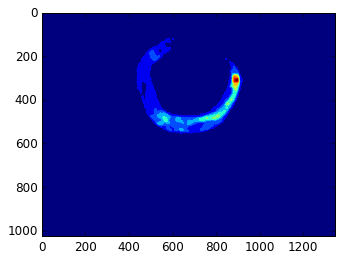

In [6]:
### Load image

image = tiff.imread(fl)

imghsv = color.rgb2hsv(image)
imgrgb = img_as_float(image)

gray = color.rgb2gray(image)
image_rescale=exposure.rescale_intensity(image)

#Image dimensions
image.shape

### Label worms
image_jet=jetimage(gray)

#plt.imshow(image_jet)

v = imghsv[:, :, 2]

# Filtering noise
dv = rank.median(v, disk(3)) / 255.0
#Expanding 
comb = opening(dv, selem=disk(5))

v1D = np.around(v.ravel(), 3)
ftable = np.array(freqtable(v1D))
ftable = ftable[np.argsort(ftable[:, 0])]
X, Y, mu, sd = fitgauss(ftable[:, 0], ftable[:, 1])

#Save image
skio.imsave('{}_{}_{}_adjusted_RGB.tiff'.format(rep,fol,fil),jetimage(comb))

plt.imshow(comb)

Threshold: 0.0300, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0310, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0320, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0330, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0340, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0350, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0360, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0370, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0380, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0390, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0400, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0410, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0420, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0430, Worm size: 1376256 Image covered: 100.00%
Threshold: 0.0440, Worm size: 63776 Image covered: 4.63%
Threshold: 0.0450, Worm size: 63776 Image covered: 4.63%


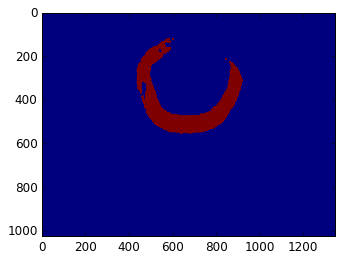

In [11]:
hthr=mu + sd * 0.5

umarks=[0]
wsize=0
imgprc=100

iter=0
total=np.sum(comb >0)

hthri=0.04
step=0.001

#wsize < 40000 or wsize > 65000 
while (imgprc<3 or imgprc>5) and iter<100 and hthri<0.06:
    markers = np.zeros_like(comb)
    # Mark background
    imgprc=np.float(np.sum(comb > hthri)*100)/total
    
    markers[comb > hthri] = 2
    umarks=np.unique(markers)
    wsize=np.count_nonzero(markers[markers==2])
    print("Threshold: {:.4f}, Worm size: {:d} Image covered: {:.2f}%".format(hthri,wsize,imgprc))
    hthri+=step
    iter+=1

markers[comb == 0] = 1

print("Threshold: {:.4f}, Worm size: {:d} Image covered: {:.2f}%".format(hthri,wsize,imgprc))
plt.imshow(markers)

/usr/local/lib/python2.7/site-packages/matplotlib/artist.py:210: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


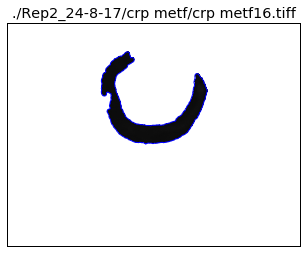

In [12]:
distance = ndi.distance_transform_edt(markers)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=markers)
markersmaxi = ndi.label(local_maxi)[0]
segmentation = watershed(distance, markersmaxi, mask=markers)
segmentation_fill = ndi.binary_fill_holes(segmentation)
labeled_worms, _ = ndi.label(segmentation_fill)
#plt.imshow(labeled_worms)

for w in list(np.unique(labeled_worms)):
    # print labeled_worms[labeled_worms==w].shape[0]
    if labeled_worms[labeled_worms == w].shape[0] < 1000:
        labeled_worms[labeled_worms == w] = 0
        
labeled_worms = opening(labeled_worms, selem=disk(10))

wormind = list(np.unique(labeled_worms))
worms = {w: labeled_worms[labeled_worms == w].shape[0] for w in wormind}
worms = {wk: wp for wk, wp in worms.items() if wp < 1000000}



row=0
col=0

fig, axes = plt.subplots(nrows=1)#, ncols=1, figsize=(6, 3), dpi=300
#fig.suptitle('{}-{}'.format(replicate, plate), fontsize=40)
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=2, wspace=0.5, hspace=0.1)


ax=axes#[row,col]

plotcontours(imgrgb,ax,labeled_worms,fl,plotlabels=False)


# fig.tight_layout()


# fig.savefig('test.pdf', bbox_inches='tight')
# plt.close(fig)


plt.show()

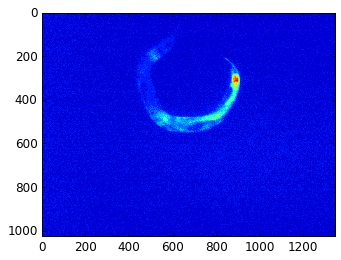

In [13]:
plt.imshow(image[:,:,2])

In [14]:
worm=1
print np.sum(image[labeled_worms==worm,:])/np.sum(np.isin(labeled_worms, worm))
print np.sum(np.isin(labeled_worms, worm))

38.93493328994468
61460


In [52]:
time.ctime()

'Thu Mar  1 14:06:08 2018'

In [58]:
filesel=glob.glob('./Rep1*/crp metf/*.tiff')
ofig='Rep1_crp_metf_test.pdf'
otbl='CRP_test_results.csv'

odata="CRP_Data.pkl.gz"

header=['Replicate folder', 'Folder', 'File', 'Worm','W_N','W_Sum','W_Mean','B_N','B_Sum','B_Mean']

loaddata=True

In [60]:
# rndsel=np.random.randint(len(allfiles)-1,size=5)
# filesel=[ allfiles[i] for i in rndsel ]

ncols=2
row=0


fig, axes = plt.subplots(nrows=len(filesel), ncols=2, figsize=(6*ncols,5*len(filesel)), dpi=300)
#fig.suptitle('{}-{}'.format(replicate, plate), fontsize=40)
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=2, wspace=0.5, hspace=0.1)





results_data=[]


print time.ctime()
if loaddata:
    idata = gzip.open(odata,'rb')
    ifiles, images, labels = cPickle.load(idata)
    idata.close()
else:
    ifiles=[]
    imagesarray=[]
    labelsarray=[]
    


for flid, fl in enumerate(filesel):
    print(fl)
    
    rep,fld,fln=fl.split('/')[1:]
    flname,flex=fln.split('.')
    
    if loaddata:
        #GetRGB data from a collapsed image
        image_raw=images[flid]
        if np.ndim(image_raw)==2:
            image=color.gray2rgb(image_raw)
        else:
            image=image_raw
        
    else:
        image = tiff.imread(fl)

    imghsv = color.rgb2hsv(image)
    #imgrgb = img_as_float(image)
    v=imghsv[:,:,2]
    image_jet=jetimage(v,typeadjust=False)
    
    #gray = color.rgb2gray(image)
    
    if loaddata:
        labeled_worms=labels[flid]
        
        wormind = list(np.unique(labeled_worms))
        
        worms = {w: labeled_worms[labeled_worms == w].shape[0] for w in wormind}
        worms = {wk: wp for wk, wp in worms.items() if wp < 1000000}
        
        contours = measure.find_contours(labeled_worms, 0.8)
    else:
        comb,labeled_worms,contours,worms=labeller4(v)
        ifiles.append(fl)
        #Save only one layer, as they are redundant
        if np.sum(image[:,:,0]-image[:,:,1])==0:
            imagesarray.append(image[:,:,0])
        else:
            imagesarray.append(image)
        labelsarray.append(labeled_worms)
    
    
    b_sz=np.sum(np.isin(labeled_worms,0))
    b_sum=np.sum(image[labeled_worms==0,0])
    b_mean=b_sum/b_sz
    
    
    for w in worms.keys():
        w_sz=np.sum(np.isin(labeled_worms, w))
        w_sum=np.sum(image[labeled_worms==w,:])
        w_mean=w_sum/w_sz
        
        results_data.append([rep,fld,fln,w,w_sz,w_sum,w_mean,b_sz,b_sum,b_mean])
    
    plotcontours(image_jet,axes[row,0],ylabel=flname,title='Normalised intensity',plotcontour=False,plotlabels=False,white=False)
    plotcontours(imgrgb,axes[row,1],labeled_worms,title='Segmented',plotlabels=True)
    row+=1
    

    
#fig.tight_layout()
fig.savefig(ofig, bbox_inches='tight')
plt.close(fig)

results = pd.DataFrame(results_data,columns=header)
results.to_csv(otbl)

if not loaddata:
    labels=np.stack(labelsarray, axis=0)
    images=np.stack(imagesarray, axis=0)

    print("Saving all data")
    f = gzip.open(odata, "w")
    cPickle.dump((ifiles,images,labels), f)
    f.close()
    print("Saving complete!")
    
print time.ctime()


Thu Mar  1 17:11:48 2018
./Rep1_23-8-17/crp metf/crp metf TF17.tiff
./Rep1_23-8-17/crp metf/crp metf TF16.tiff
./Rep1_23-8-17/crp metf/crp metf TF1.tiff
./Rep1_23-8-17/crp metf/crp metf TF6.tiff
./Rep1_23-8-17/crp metf/crp metf TF11.tiff
./Rep1_23-8-17/crp metf/crp metf TF10.tiff
./Rep1_23-8-17/crp metf/crp metf TF7.tiff
./Rep1_23-8-17/crp metf/crp metf TF8.tiff
./Rep1_23-8-17/crp metf/crp metf TF13.tiff
./Rep1_23-8-17/crp metf/crp metf TF4.tiff
./Rep1_23-8-17/crp metf/crp metf TF5.tiff
./Rep1_23-8-17/crp metf/crp metf TF12.tiff
./Rep1_23-8-17/crp metf/crp metf TF9.tiff
./Rep1_23-8-17/crp metf/crp metf TF15.tiff
./Rep1_23-8-17/crp metf/crp metf TF2.tiff
./Rep1_23-8-17/crp metf/crp metf TF19.tiff
./Rep1_23-8-17/crp metf/crp metf TF18.tiff
./Rep1_23-8-17/crp metf/crp metf TF3.tiff
./Rep1_23-8-17/crp metf/crp metf TF14.tiff
Thu Mar  1 17:12:16 2018
